<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M3/notebooks/M3_CNN_Intro_Cats%26Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On Cats, Dogs and Hotdogs
## Intro to Convolutional Neural Networks and Computer Vision


In this notebook you will learn about the different building blocks that form a convolutional neural net as well as how we can build one using Keras. CNNs are the kind of neural networks that really require computational resources and therefore, you should consider using Colab/Kaggle with GPU (or TPU support if you can figure it out) support to run that. If you run it on your own computer without a GPU things will take a lot of time...like a lot!


### Building a cats and dogs classifier

In [1]:
# Let's start by downloading and exploring the data
!wget -qq https://storage.googleapis.com/sds-file-transfer/dataset.zip
# We need to unzip the data...and as you can see there is a lot
!unzip -qq dataset.zip

The data is actually a folder with 3 folders inside it. A *training_set*, a *test_set* and another one for try-outs

In each the training and test_set folders we have 2 folders again. One for cats and one for dogs.
Here some examples:

![alt text](https://source.unsplash.com/7AIDE8PrvA0/200x300)
![alt text](https://source.unsplash.com/h7VBJRBcieM/200x300)



Now think, you are a computer and need to classify that. :-O



### Importing Keras and some special layers

In the last session we played with the Dense and Dropout layers. When working with CNNs we will be dealing with a few other building blocks: 

Conv2D, MaxPooling2D, and Flatten.


Let's load them first and then take one by one and try to understand what they are doing.


In [2]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
# We initialise the classifier just as before using the sequential model. Nothing new here

classifier = Sequential()

#### Adding the first convolutional layer

In [4]:
# Step 1 - Convolution - This is new
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

First, we should perhaps get an overall picture of how a CNN architecture looks.

![alt text](https://cdn-images-1.medium.com/max/2000/1*w5peCK-AeSI9D0PRT8oiZw.png)


```
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
```

we use 32 different filters that will be built as 3x3 matrices. We also specify that our input shape is 64x64x3, meaning that we have 3 matrices (for RGB) of 64 pixels each side.




In [5]:
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

#### Adding MaxPooling


```
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
```

Adding that layer requires just to specify the size of the "pool" - and we are done. 

Now, let's check out [something fun:](http://scs.ryerson.ca/~aharley/vis/conv/)



In [6]:
# And now, we just repeat the another time :-)


classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [7]:
# Step 3 - Flattening
classifier.add(Flatten())

This layer is easy: Take all pooled features and line them up in one long vector, then convatenate.

In [8]:
# Finally: We add a "regular" artificial neural net including a bit of dropout (not really needed but why not)
# The final layer has a sigmoid activation function due to the binary classification problem.

classifier.add(Dense(units = 128, activation = 'relu'))
#classifier.add(Dropout(rate = 0.2))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [9]:
# We compile the network just as any other neural net
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

#### Now the data preprocessing and streaming

We are now done with building the architecture. Now the "data-engineering" part, which i find a bit tricky.
Our input are a bunch of jpeg images with cats and dogs.
Obviousely (I hope), we are not going to load the images into memory with pandas or something like that. Rather we are going to stream them during training one batch at a time. 
However, we cannot just throw a jpeg at the network. That wouldn't be nice. We need to transform the images to matrices on the fly. Another thing that we also will do is "image augmentation". 



> Image Augmentations techniques are methods of artificially increasing the variations of images in our data-set by using horizontal/vertical flips, rotations, variations in brightness of images, horizontal/vertical shifts etc.



You can read more on that and in general about generators [here](https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad).

![alt text](https://cdn-images-1.medium.com/max/1600/1*rZRYWg0ve6bZv2-ctEtVXg.png)

![alt text](https://cdn-images-1.medium.com/max/1600/1*0aMp3TW3rxCUL1JFmeJj9Q.png)

In [11]:
# Importing the Keras-Image-Data-Generator <3 Keras ppl

from keras.preprocessing.image import ImageDataGenerator


# Defining the generators. Note, that we for obvious reasons only apply all of the generator magic to the training set.

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# here, we specify the size of the images that we want (which needs to fit the input size of our network)
# We also set the batch size and the classification method (here binary)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
!cd dataset/training_set; ls

cats  dogs


In [16]:
# And now we can train the network

classifier.fit_generator(training_set,
                         steps_per_epoch = 800,
                         epochs = 2,
                         validation_data = test_set,
                         validation_steps = 100)

Epoch 1/2
250/800 [========>.....................] - 33s 133ms/step - loss: 0.6046 - accuracy: 0.6697 - val_loss: 0.5562 - val_accuracy: 0.7215


In [20]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)

test_image = np.expand_dims(test_image, axis = 0)

result = classifier.predict(test_image)



print(training_set.class_indices)

if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    
print(prediction)

{'cats': 0, 'dogs': 1}
dog


In [21]:
import glob

In [23]:
for i in glob.glob('dataset/test_set/dogs/*')[:10]:
  test_image = image.load_img(i, target_size = (64, 64))
  test_image = image.img_to_array(test_image)

  test_image = np.expand_dims(test_image, axis = 0)

  result = classifier.predict_classes(test_image)
  if result[0][0] == 1:
    print('dog')
  if result[0][0] == 0:
    print('cat')
  

dog
cat
dog
dog
dog
dog
dog
cat
dog
cat


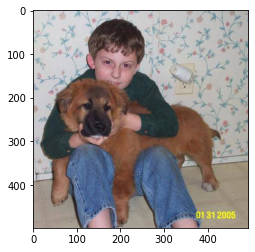

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread(glob.glob('dataset/test_set/dogs/*')[8])
plt.imshow(img)

In [25]:
# Preditions come as a ndarray
result[0][0]

0

In [26]:
# Evaluation returns loss and accuracy
classifier.evaluate_generator(test_set, steps=500)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.5561606884002686, 0.7214999794960022]

In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/vIci3C4JkL0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

#### Your turn:



![alt text](https://cdn-images-1.medium.com/max/2000/1*zlkcoZ6TfAnnv78eOlLnpw.jpeg)

[Build a hotdog-not-hotdog classifier](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog)

You can get the data here: https://storage.googleapis.com/sds-file-transfer/hot-dog-not-hot-dog.zip a bit faster...